# 🇬🇧 BBC NEWS CLASSIFICATION PROJECT 
## *(Unsupervised Learning Project)*
#### 🏫 University of Colorado, Boulder - Unsupervised Algorithms in Machine Learning 
*By Mattison Hineline*


**Overview**

This project looks at an unsupervised learning model technique called matrix factorization. All the required libraries to run the notebook are in the first coding cell. This notebook explores the training data while using common natural language processing techniques. Our goal is to classify different news articles into five different groups: business, tech, sport, entertainment or politics. We will train two models: (1) an unsupervised model using matrix factorization and then compare it with (2) a supervised model using KMeans clustering. Both models are submitted to have their testing accuracy. 


**1. Exploratory Data Analysis (EDA)🥸** 

In this section we will explore the data given for the competition. It is important to look at what you have to work with before beginning any model building or model training. Normally, it is suggested to first split the data into training and testing sets before any EDA because you, as a researcher, do not want to be biased for the results which can lead to overfitting. For this reason, we will not visualize or explore the test data given, and use that data only for testing the models. 

**2. Model Building and Training 🦾**

Next, we will build multiple unsupervised models and train them on the test data. Once we have at least two strong models built, we will fine-tune those models and test on the test dataset. We will be using the train-test split on this dataset that is already given in the CSV files.

**3. Model Comparisons 🧐**

Once we have good, working models we will compare them for their performance. We will discuss which model is the best out of the models tested and why. 

**4. Conclusions 🤓**

Finally, we will summary the project and results, including future suggestions for further analysis. 

In [1]:
#import important libraries
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os

#EDA and preprocessing
import re
import nltk.corpus
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from string import digits

#modeling
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF
from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics
import itertools
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

#find the files names
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/learn-ai-bbc/BBC News Train.csv
/kaggle/input/learn-ai-bbc/BBC News Sample Solution.csv
/kaggle/input/learn-ai-bbc/BBC News Test.csv


In [2]:
#label file paths
path_dir = '/kaggle/input/learn-ai-bbc/'
train_path = path_dir + 'BBC News Train.csv'
sample_solution_path = path_dir + 'BBC News Sample Solution.csv'
test_path = path_dir + 'BBC News Test.csv'

In [3]:
#import data
train = pd.read_csv(train_path)
sample_solution = pd.read_csv(sample_solution_path)
test = pd.read_csv(test_path)

________
# 1. Exploratory Analysis (EDA)
_____

In [4]:
#look at what we are trying to submit 
sample_solution

,ArticleId,Category
0,1018,sport
1,1319,tech
2,1138,business
3,459,entertainment
4,1020,politics
...,...,...
730,1923,sport
731,373,tech
732,1704,business
733,206,entertainment


After importing the data, we first take a look at what our ultimate goal for the project is by looking at the submission dataframe (above). We need to create a dataframe comprising of classified articles (ArticleId) and which category they belong to (category). We also see that each ArticleID is unique, while the categories repeat themselves. This is good information to know before continuing. Now that we know our end goal structure, let's move on to the training data. 

We can see in the dataframe below that we have three columns: 
1. ArticleID: which is the identifying number for the article
2. Test: the article header and text
3. Category: category given to the article

In [5]:
#look at the training data
train

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business
...,...,...,...
1485,857,double eviction from big brother model caprice...,entertainment
1486,325,dj double act revamp chart show dj duo jk and ...,entertainment
1487,1590,weak dollar hits reuters revenues at media gro...,business
1488,1587,apple ipod family expands market apple has exp...,tech


In [6]:
# gain more information from the dataframe
train.describe()

,ArticleId
count,1490.000000
mean,1119.696644
std,641.826283
min,2.000000
25%,565.250000
50%,1112.500000
75%,1680.750000
max,2224.000000


In [7]:
#check the type of data, null value counts and number of entries
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB


Great. All this information look as we expected. We have two object columns and one integer column (for the ID's). It looks like we are not missing any rows. Since the data we are working with is text, we don't need to worry about numbers that are missing such as 9999, 0, etc. Before continuing, I want to make sure that we have no repeated articles in the data. From the code below, we can see that we have 1490 unique IDs and we know the dataframe has 1490 rows, we can assume that each article is unique and continue. I also wanted to see how many categories there are. We can see below that there are five categories in total: business, tech, politics, sport, entertainment.

In [8]:
# check for repeated articles
train['ArticleId'].nunique()

1490

In [9]:
train['Category'].unique()

array(['business', 'tech', 'politics', 'sport', 'entertainment'],
      dtype=object)

The first thing I want to look at is a couple of texts to get an idea of how they are saved in the dataframe. We will look at the first row.  We can see that the text starts with the header, then has a fairly good amount of text afterwards which would be the article text. We can see that the data has already been preprocessed a bit because there are no uppercase characters. Since these are news articles, we can also assume that there are no spelling mistakes. Capitalization and spelling are two important factors when it comes to natural language processing. For this reason, we will be thankful that this has already been processed as such. 

In [10]:
# first row 
train['Text'][0]

'worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  worldcom s ex-head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy.  prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates. but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early 2001 and 2002. she said andersen had given a  green light  to the procedures and practices used by worldcom. mr ebb

Now let's visualize the data as much as we can before running some models. We can see that overall we have about even number of entries for each category. This is good because if one or two categories was severely underrepresentated or, in contrast, overrepresentative in the data, then it may cause our model to be biased and/or perform poorly on some or all of the test data. 

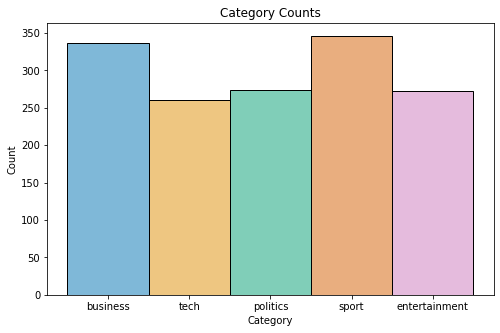

In [11]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.histplot(
    data = train,
    x = 'Category',
    hue = 'Category',
    palette = 'colorblind',
    legend = False,
    ).set(
        title = 'Category Counts');

While working with text data, it is important to make the text "readable" for the computer. To do this, we will take three steps:
1. remove punctuation
2. remove stop words (common English words such as 'to', 'the', 'of', etc

In [12]:
def clean_text(dataframe, text_col):
    '''
    A helper function which takes a dataframe 
    and removes punction and stopwords.
    '''
    #remove all punctuation
    dataframe['no_punct'] = dataframe[text_col].apply(lambda row: re.sub(r'[^\w\s]+', '', row))
    
    #remove numbers 
    dataframe['no_punct_num'] = dataframe['no_punct'].apply(lambda row: re.sub(r'[0-9]+', '', row))
    
    #remove stopwords
    stop_words = stopwords.words('english')
    dataframe['no_stopwords'] = dataframe['no_punct_num'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
    
    #remove extra spaces
    dataframe['clean_text'] = dataframe['no_stopwords'].apply(lambda x: re.sub(' +', ' ', x))
    return 

In [13]:
#clean dataframe text column
clean_text(train, 'Text')

In [14]:
train['clean_text'][1]

'german business confidence slides german business confidence fell february knocking hopes speedy recovery europe largest economy munichbased research institute ifo said confidence index fell february january first decline three months study found outlook manufacturing retail sectors worsened observers hoping confident business sector would signal economic activity picking surprised ifo index taken knock said dz bank economist bernd weidensteiner main reason probably domestic economy still weak particularly retail trade economy labour minister wolfgang clement called dip february ifo confidence figure mild decline said despite retreat index remained relatively high level expected modest economic upswing continue germany economy grew last year shrinking however economy contracted last three months mainly due reluctance consumers spend latest indications growth still proving elusive ifo president hanswerner sinn said improvement german domestic demand sluggish exports kept things going f

After cleaning the dataframe text cells, we will also tokenize and lemmatize the text. Tokenize entails splitting a string of words into a list of words. For example "cat sat on dog" would be converted to ['cat', 'sat', 'on', 'dog']. Tokenizing splits up each word which we can then use later on to train models easier. Next, we will lemmatize the text. We can choose to lemmatize or stem the words. For this project, I chose to lemmatize the words because it keeps a bit more informationn than would stemming. An example of lemmatizing would be to take the words 'running', 'horses', and 'adjustable', and we lemmatize them to be 'run', 'horse', 'adjust'. This keeps the words general meaning but allows the model to learn better. Additionally, we will ensure that all words are in lowercase form. These cleaning steps mentioned before and here are important because, for example, the computer could look at two sentences such as "Running big reddish dogs." versus "Run big red dog!" and these would be considered different even though they are quite similar. After cleaning, both sentences would be converted to ['run', 'big', 'red', 'dog'] and therefore these two "articles" probably would be classified together, which is the goal of our model.

In [15]:
# tokenize text function
wordnet_lemmatizer = WordNetLemmatizer()
def lemmatizer(text):
    ''' 
    A helper function to lemmatize an entire sentence/string
    '''
    lem = [wordnet_lemmatizer.lemmatize(word.lower()) for word in text] 
    return lem

def tokenize_lemmatize(dataframe, text_col):
    '''
    A helper function to tokenize then lemmatize the string.
    Also, add column which counts the number of words in that string.
    '''
    dataframe['tokenized'] = dataframe.apply(lambda row: nltk.word_tokenize(row[text_col]), axis=1)
    dataframe['lemmatized'] = dataframe['tokenized'].apply(lambda string: lemmatizer(string))
    dataframe['num_words'] = dataframe['lemmatized'].apply(lambda lst: len(lst))
    return

In [16]:
tokenize_lemmatize(train, 'clean_text')

After cleaning, we can see (below) the number of words per article. We see most articles are around 200 words. However, we also see we have some severe outliers that reach up to more than 750 words! We actually will remove these outliers as they might actually impact our model later on, in addition to creating more features (words) to have to calculate within the model. 

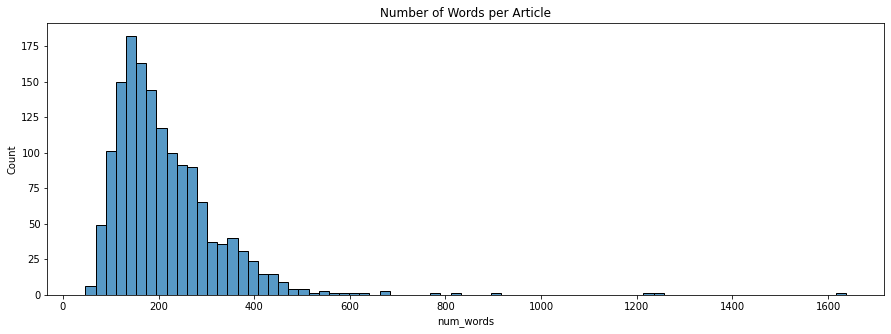

In [17]:
# number of tokens (words) per article
fig, ax = plt.subplots(figsize=(15, 5))
sns.histplot(
    data = train, 
    x = 'num_words',
    palette = 'colorblind',
    ).set(
        title = 'Number of Words per Article');

In [18]:
#remove outlier articles (longer than 750 words)
train = train[train['num_words'] < 750]
len(train)

1484

Let's also look at the number of words per category (boxplot below). Per category, we also see quite a few outliers. We will leave these this time. We also see that the mean of each category is similar, with tech and politics having more words, and variance, than the rest of the topics.

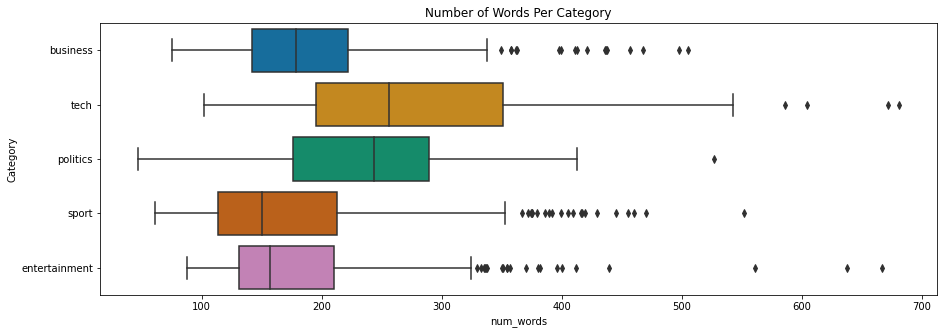

In [19]:
# words per category
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(
    data = train, 
    x = 'num_words', 
    y = 'Category',
    palette = 'colorblind'
    ).set(
        title = 'Number of Words Per Category');

-------
# 2. Model Building and Training 
-----



In [20]:
train_df = train.copy()

In [21]:
def predict(w_matrix):
    sortedW = np.argsort(w_matrix)
    n_predictions, maxValue = sortedW.shape
    predictions = [[sortedW[i][maxValue - 1]] for i in range(n_predictions)]
    topics = np.empty(n_predictions, dtype = np.int64)
    for i in range(n_predictions):
        topics[i] = predictions[i][0]
    return topics

In [22]:
def label_permute(ytdf,yp,n=5):
    """
    ytdf: labels dataframe object
    yp: clustering label prediction output
    Returns permuted label order and accuracy. 
    Example output: (3, 4, 1, 2, 0), 0.74 
    """
    perms = list(itertools.permutations([0, 1, 2, 3, 4]))    #create permutation list
    best_labels = []
    best_acc = 0 
    current = {}
    labels = ['business', 'tech', 'politics', 'sport', 'entertainment']
    for perm in perms:
        for i in range(n):
            current[labels[i]] = perm[i]
            if len(current) == 5:
                conditions = [
                    (ytdf['Category'] == current['business']),
                    (ytdf['Category'] == current['tech']),
                    (ytdf['Category'] == current['politics']),
                    (ytdf['Category'] == current['sport']),
                    (ytdf['Category'] == current['entertainment'])]
                ytdf['test'] = ytdf['Category'].map(current)
                current_accuracy = accuracy_score(ytdf['test'], yp)
                if current_accuracy > best_acc: 
                    best_acc = current_accuracy
                    best_labels = perm
                    ytdf['best'] = ytdf['test']
    return best_labels, best_acc

In [23]:
#create vectorizer
tfidvec = TfidfVectorizer(min_df = 2,
                          max_df = 0.95,
                          norm = 'l2',
                          stop_words = 'english')
tfidvec_train = tfidvec.fit_transform(train_df['clean_text'])

#create model
nmf_model = NMF(n_components=5, 
                init='nndsvda', 
                solver = 'mu',
                beta_loss = 'kullback-leibler',
                l1_ratio = 0.5,
                random_state = 101)
nmf_model.fit(tfidvec_train)

#view results
yhat_train = predict(nmf_model.transform(tfidvec_train))
label_order, accuracy = label_permute(train_df, yhat_train )
print('accuracy=', accuracy)

accuracy= 0.9609164420485176


For this model, using matrix factorization, I found the best combination of parameters as above which resulted in the highest accuracy. I also tried other combinations, changing the TfidVectorizor and/or NMF model parameters. Particularly, I played around with min_df and man\x_df in the TfidVectorizor
- using max_df values of 0.85, 0.90, 0.95
- using min_df values of 0, 1, and 2
- using beta_loss of 'frobenius' and 'kullback-leibler'
- using solver of 'mu' and 'cd'

Although all models performed with higher than 85%, the combination above (in the code) was the best model.

In [24]:
#show best labels for the trained model 
label_dict = {4:'business', 2:'tech', 1:'politics', 0:'sport', 3:'entertainment'}
for i in range(5):
    print(f'{label_order[i]}:  {label_dict[label_order[i]]}')

4:  business
2:  tech
1:  politics
0:  sport
3:  entertainment


In [25]:
#first clean testing data as we did with the training data
clean_text(test, 'Text')
tfidvec_test = tfidvec.transform(test['clean_text'])
yhat_test = predict(nmf_model.transform(tfidvec_test))

In [26]:
#create a submission dataframe
test_predictions = pd.DataFrame(columns=['ArticleId', 'Category', 'yhat'])
test_predictions['ArticleId'] = test['ArticleId']
test_predictions['yhat'] = yhat_test
test_predictions['Category'] = test_predictions['yhat'].apply(lambda i: label_dict[i])

#delete columns unneeded for submission
test_predictions = test_predictions.drop('yhat', 1)
print(test_predictions.head(15))

    ArticleId       Category
0        1018          sport
1        1319           tech
2        1138          sport
3         459       business
4        1020          sport
5          51          sport
6        2025       politics
7        1479       politics
8          27  entertainment
9         397       business
10       1644       business
11        263           tech
12        765       politics
13       2134           tech
14        297  entertainment


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


In [27]:
#save and submit test dataframe
try: 
    test_predictions.to_csv('submission.csv', index=False)
except: 
    pass

# #public and private score was 0.96326

To get the accuracy on the test set, I went ahead and submitted the results from the unsupervised model. Our model got a test accuracy score of 0.96326, or 96.3%, which is pretty good! Let's see if we can do even better using a supervised model. 

_______
# 3. Model Comparisons 

For this project, we are asked to use unsupervised learning to classify text articles uing a matrix factorization model. Traditionally, supervised models would perform better with this type of data if we have pre-labeled text, which we do. Therefore, we will compare the unsupervised learning model above to a supervised model below. Since there was no given direction for which supervised model to use specifically, for fun let's try a KMeans clustering model. 
For good measure, we will re-import the data again since we'll be working with a new model. 

In [28]:
#import data
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

In [29]:
#clean data
clean_text(train, 'Text')

#split data into X and y
y_train = train['Category'].values
X_train = train['clean_text'].values

#create new vectorizer for supervised learning model
tfidfvec_supervised = TfidfVectorizer(min_df = 2,
                          max_df = 0.95,
                          norm = 'l2',
                          stop_words = 'english')
tfSuper_train = tfidfvec_supervised.fit_transform(X_train) 

#create KMeans Model and train
kmeans = KMeans(n_clusters = 5, 
                init = 'k-means++', 
                algorithm = 'full', 
                random_state = 101)
yhat_train_super = kmeans.fit_predict(tfSuper_train)

#get accuracy
y_train_df = pd.DataFrame(y_train, columns=['Category'])
label_order, accuracy = label_permute(y_train_df, yhat_train_super)
print('accuracy=', accuracy)
print(label_order, '\n')

#show label order
label_dict = {3:'business', 1:'tech', 4:'politics', 2:'sport', 0:'entertainment'}
for i in range(5):
    print(f'{label_order[i]}:  {label_dict[label_order[i]]}')

accuracy= 0.9369127516778524
(3, 1, 0, 2, 4) 

3:  business
1:  tech
0:  entertainment
2:  sport
4:  politics


Now we will test the model on the test set. Again, we need to repeat the same steps to clean the data like we did in the training set. 

In [30]:
#clean data
clean_text(test, 'Text')

#split data
X_test = test['clean_text'].values

#create vectorizer (do not fit it!)
tfSuper_test = tfidfvec_supervised.transform(X_test)
yhat_test = kmeans.predict(tfSuper_test)

#create a submission dataframe
test_predictions = pd.DataFrame(columns=['ArticleId', 'Category', 'yhat'])
test_predictions['ArticleId'] = test['ArticleId']
test_predictions['yhat'] = yhat_test
test_predictions['Category'] = test_predictions['yhat'].apply(lambda i: label_dict[i])

#delete columns unneeded for submission
test_predictions = test_predictions.drop('yhat', 1)
print(test_predictions.head(2))

   ArticleId Category
0       1018    sport
1       1319     tech


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


In [31]:
#save and submit test dataframe
# try: 
#     test_predictions.to_csv('submission.csv', index=False)
# except: 
#     pass

# #public and private score was 0.62993

It looks like we got a training accuracy of 93.69% but only a testing accuracy of 62.99%. Wow! This suggests that our model is probably overfitting to the training data and does a poor job predicting on new data. If we wanted to train a more powerful supervised learning model, we could use techniques such as ensemble methods and/or cross-validation (Kfold), or different models such as decision tree, random forest, SVM, etc. However, since this class focuses on unsupervised learning techniques, and that is our main focus in this project, we will simply compare our KMeans model to the matrix factorization model. 

______ 
# 4. Conclusions
______

To summarize this project, we first cleaned the training data in common NLP preprocessing ways and explored the data. Then we created a matrix factorization model and got a testing accuracy of 96.3%. We got this score by find-tuning some parameters and using the training accuracy as a guide. The unsupervised model did quite well coompared to the supervised learning model. I suspect the supervised model overfit to the training data, which our unsupervised model did not. We made sure to preprocess the data in the same way for all training and testing runs. 


**Future Project Enhancement Options**: 
Here are a few things that could be performed in future NLP projects which may impact the results in this study by improving or decreasing the performance. It is worth trying out. This project removed captialized letters, all numbers, and punctuation. In addition, we did not deal with mispelled or 'non-real' words. These things can impact the outcomes of a model and are worth modifying and trying out in different ways to see if better results can be obtained.


End 🥳
______